## Space Mission Case Study

This case study demonstrates using Pacti for the verification of an autonomous space mission system that uses an onboard planning/scheduling system based on a generalized timeline representation as described in [Chien et al. 2012](#ref1). Examples of such timeline representation modeling include [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3). Such systems reflect deliberate design decisions to limit the expressiveness of constraint formulas for planning/scheduling due to considerations of the limited computational resources available on space mission systems and performance requirements for computing solutions. In contrast to the general class of 1st order constraint formulas of PDDL (see [Ghallab et al. 1998](#ref4)), such systems involve computationally efficient linear inequalities of the form:

$$aX <= b$$

where $$x$$ is a timeline variable and $$a,b$$ are constants that may encode temporal information about the schedule of a task instance.

Since this class of constraint formula fits the expressiveness of Pacti's polyhedral constraints, this case study explores modeling tasks for an onboard automated planning/scheduling system as assume-guarantee components using Pacti.

In [1]:
%matplotlib widget

from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

varPrefixes=["t", "soc", "d", "e", "r", "temp"]
epsilon = 1e-3

## A simple space mission scenario

The following figure illustrates a simplified space mission scenario for a cubesat-sized spacecraft to approach a small body asteroid described in more detail in [Nesnas et al. 2021](ref5). Note: the Sun, Earth, spacecraft and small body asteroid are shown at different scales for illustration purposes.

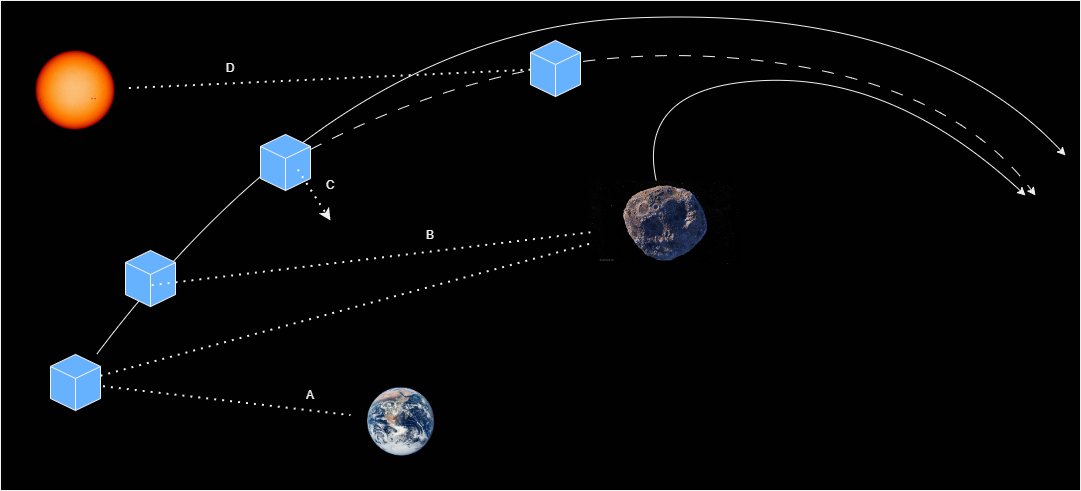

In [2]:
display.Image(b64decode(figure_space_mission_scenario))


To communicate with Earth, the cubesat-sized spacecraft (blue cube) must orient its fixed antennas towards Earth (line A). Depending on the trajectory, this orientation may be suboptimal for the spacecraft panels to produce maximum electrical power (line B). The spacecraft must make optical measurements of the small body asteroid to estimate its relative trajectory (line C) as part of the onboard autonomous navigation. This navigation requires pointing the spacecraft's thrusters in the direction of a velocity vector (line D) according to a trajectory correction maneuver (TCM). After several carefully designed TCMs, the spacecraft will eventually reach the small body asteroid and land on it as described in [Nesnas et al. 2021](ref5). For onboard planning/scheduling these behaviors would be modeled as tasks in the style of [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3); that is, tasks would involve linear inequality constraints for specifying their pre/post conditions and their effects. The following describes the specification of these behaviors in Pacti's assume-guarantee paradigm.

### Modeling task behaviors as assume-guarantee contracts

The simplified space mission scenario described above involves the following tasks:

| Task Name | Task Description | Pointing Constraint |
| --------- | ---------------- | ------------------- |
| DSN       | Communicate with Earth | Line A |
| PWR       | Ensure power | Line B |
| SBO       | Acquire Small body observations | Line C |
| TCM       | Perform a Trajectory Correction Maneuver | Line D |

The result of planning/scheduling these tasks will result in a scenario as illustrated below where red dashed rectangles show the temporal extent of each scheduled task.


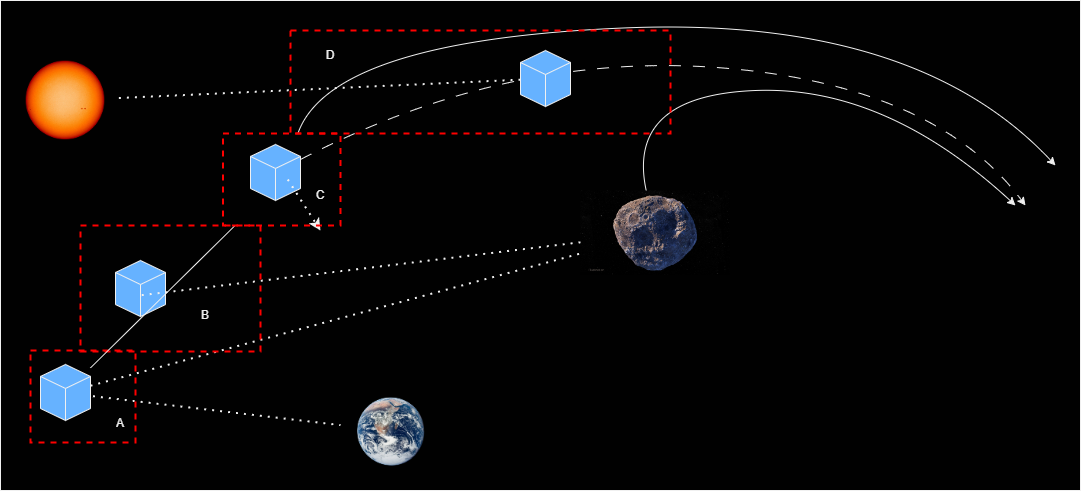

In [3]:
display.Image(b64decode(figure_space_mission_segments))



The Pacti specifications for these tasks involve the following variables:

| Variable name | Value range | Variable description |
| ------------- | ----------- | -------------------- |
| `t` | $[0-..]$ | time |
| `soc` | $[0-100]$ | Spacecraft's battery state-of-charge |
| `d` | $[0-100]$ | Spacecraft's current onboard science data storage from small body observations |
| `c` | $>= 0$ | Spacecraft cummulative science data from small body observations |
| `e` | $[0-100]$ | Spacecraft's estimation of its small-body relative trajectory error |
| `r` | $[0-100]$ | Spacecraft's relative distance (100=trajectory at beginning of scenario, 0=trajectory at rendez-vous with small body) |
| `temp` | $[0-100]$ | Spacecraft's thurster temperature (0=cold, 100=hot) |

These variables appear as inputs and outputs of Pacti component specifications as illustrated below for two components, `A` and `B` where the temporal ordering of the schedule of `B` starting after the end of the schedule of `A` corresponds to the composition of `A` and `B` in Pacti.

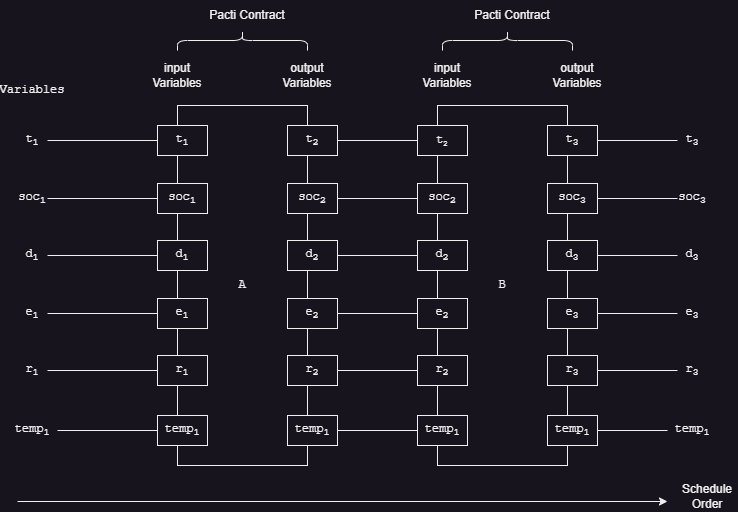

In [4]:
display.Image(b64decode(figure_task_schedule_contracts))

#### Mission scenario requirements

In [5]:
def scenario_requirements(epsilon: float) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"t_entry",    # scenario start time
      f"soc_entry",  # initial battery SOC
      f"d_entry",    # initial data storage volume
      f"c_entry",    # initial cumulative data volume
      f"e_entry",    # initial trajectory error
      f"r_entry",    # initial relative distance
      f"temp_entry", # initial spacecraft thruster temperature
    ],
    OutputVars= [
      f"t_exit",     # scenario end time
      f"soc_exit",   # final battery SOC
      f"d_exit",     # final data storage volume
      f"c_exit",     # final cumulative data volume
      f"e_exit",     # final trajectory error
      f"r_exit",     # final relative distance
      f"temp_exit",  # final spacecraft thruster temperature
    ],
    assumptions=[
      f"t_entry = 0",     # start @ t=0
      f"soc_entry = 100", # start with battery fully charged
      f"d_entry = 0",     # start with no science data storage
      f"c_entry = 0",     # start with no cumulative science data
      f"e_entry = 20",    # start with trajectory estimation error = 20% (ground-based calculations)
      f"r_entry = 100",   # start with relative distance = 100%
      f"temp_entry = 0",  # start with cold thruster temperature
    ],
    guarantees=[
      f"t_exit = 300",    # projected end @ t=300
      f"-soc_exit <= 70", # goal: battery >= 70% SOC
      f"d_exit = 0",      # goal: all science data downlinked
      f"-c_exit <= -1e4", # goal: at least 10^4 cumulative science data observations
      f"e_exit <= 1",     # goal: trajectory estimation error <= 1%
      f"r_exit <= 10",    # goal: relative distance below 10%
      f"-r_exit <= -5",   # goal: relative distance above 5%
      f"-temp_exit <= 0", # goal: no constraint on thruster temperature since they cool very quickly
    ]
  )
  return spec

def nochangeContract(s: int, name: str) -> PolyhedralContract:
  e=s+1
  return PolyhedralContract.from_string(
    InputVars=[ f"{name}{s}" ],
    OutputVars=[ f"{name}{e}" ],
    assumptions=[],
    guarantees=[ f"| {name}{e} - {name}{s} | = 0" ])

def durationContract(s: int, duration: str, epsilon: float) -> PolyhedralContract:
  e=s+1
  return PolyhedralContract.from_string(
    InputVars=[ 
      f"t{s}"   # Scheduled start time
    ],
    OutputVars=[
      f"t{e}"   # Scheduled end time
    ],
    assumptions=[
      # positive scheduled duration
      f"-{duration}{s} <= 0",
    ],
    guarantees=[ 
      # task ends after the duration has elapsed
      f"| t{e} - t{s} - {duration}{s} | <= {epsilon}",])


#### PWR Task 

Objective: charge the spacecraft battery

This function affects a single viewpoint, power, with an impact that is linear with the duration of the task.

##### PWR power viewpoint 

Contract pwr1_power:

InVars: [soc10_entry, knob_pwr10]
OutVars:[soc10_exit]
A: [
  -knob_pwr10 <= 0.0
  -soc10_entry <= 0.0
]
G: [
  -4.0 knob_pwr10 - soc10_entry + soc10_exit <= 0.0
  3.0 knob_pwr10 + soc10_entry - soc10_exit <= 0.0
  soc10_exit <= 100.0
]


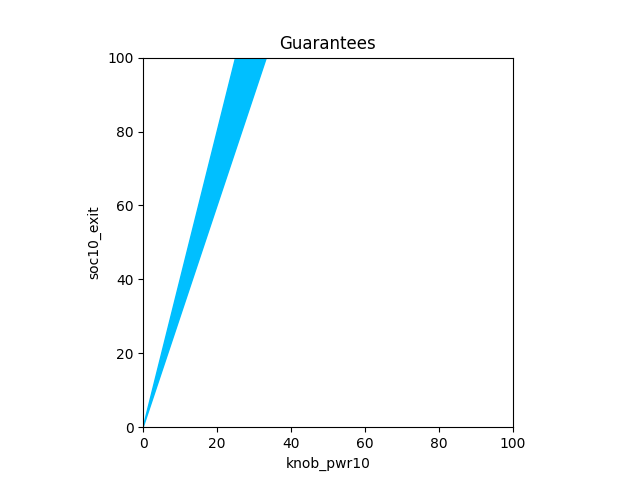

In [23]:
# Parameters:
# - s: start index of the timeline variables
# - generation: (min, max) rate of battery charge during the task instance
# - epsilon: approximately zero
def PWR_power(s: int, generation: tuple[float, float], epsilon: float) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}_entry",    # initial battery SOC
      f"knob_pwr{s}",     # variable task duration
    ],
    OutputVars = [
      f"soc{s}_exit",     # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-knob_pwr{s} <= 0",

      # Battery SOC must be positive
      f"-soc{s}_entry <= 0",
    ],
    guarantees = [
      # duration*generation(min) <= soc{e} - soc{s} <= duration*generation(max)
      f" soc{s}_exit - soc{s}_entry - {generation[1]}*knob_pwr{s} <= 0",
      f"-soc{s}_exit + soc{s}_entry + {generation[0]}*knob_pwr{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
    ])
  return spec

pwr1_power = PWR_power(s=10, generation=(3.0, 4.0), epsilon=epsilon)
print(f"Contract pwr1_power:\n\n{pwr1_power}")

_ = plot_guarantees(contract=pwr1_power,
                x_var=Var("knob_pwr10"),
                y_var=Var("soc10_exit"),
                var_values={
                  Var("soc10_entry"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

##### PWR combined viewpoints

Early merging of domain-specific viewpoints for the power segment yields the following combined contract:

In [21]:
pwr1 = \
  pwr1_power \
  .merge(nochangeContract(s=10,name="d")) \
  .merge(nochangeContract(s=10,name="e")) \
  .merge(nochangeContract(s=10,name="r")) \
  .merge(nochangeContract(s=10,name="temp"))
print(f"pwr1:\n\n{pwr1}")

pwr1:

InVars: [soc10, knob_pwr10, d10, e10, r10, temp10]
OutVars:[soc11, d11, e11, r11, temp11]
A: [
  -knob_pwr10 <= 0.0
  -soc10 <= 0.0
]
G: [
  -4.0 knob_pwr10 - soc10 + soc11 <= 0.0
  3.0 knob_pwr10 + soc10 - soc11 <= 0.0
  soc11 <= 100.0
  -d10 + d11 = 0.0
  -e10 + e11 = 0.0
  -r10 + r11 = 0.0
  -temp10 + temp11 = 0.0
]


#### DSN Task (Communicate with Earth)

Objective: downlink science data to Earth.

Side effects: consumes power.

This function affects two viewpoints, each with impacts that are linear with the duration of the task:
- power: the battery discharges proportionally to a consumption rate
- data: the downlinked data volume increases proportionally to a downlink speed

##### DSN power viewpoint

Contract dsn1_power:

InVars: [soc20, knob_dsn20]
OutVars:[soc21]
A: [
  -knob_dsn20 <= 0.0
  4.2 knob_dsn20 - soc20 <= 0.0
]
G: [
  -4.2 knob_dsn20 + soc20 - soc21 <= 0.0
  3.8 knob_dsn20 - soc20 + soc21 <= 0.0
]


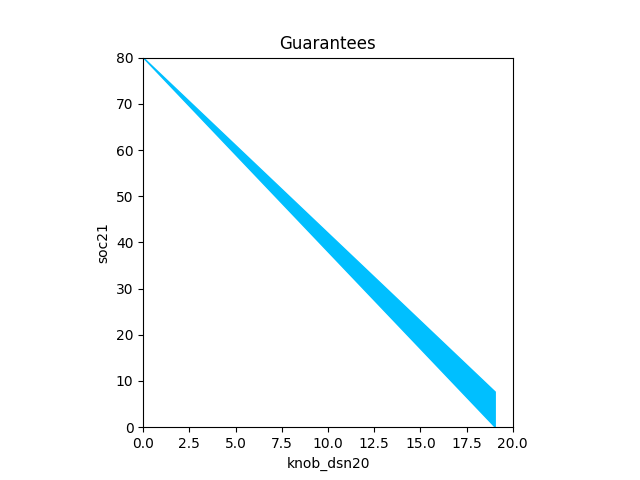

In [22]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
# - epsilon: approximately zero
def DSN_power(s: int, consumption: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}",        # initial battery SOC
      f"knob_dsn{s}",   # variable task duration
    ],
    OutputVars = [
      f"soc{e}",        # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-knob_dsn{s} <= 0",

      # Battery has enough energy for worst-case consumption throughout the task instance
      f"-soc{s} + {consumption[1]}*knob_dsn{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{s} - soc{e} <= duration*consumption(max)
      f" soc{s} - soc{e} - {consumption[1]}*knob_dsn{s} <= 0",
      f"-soc{s} + soc{e} + {consumption[0]}*knob_dsn{s} <= 0",

      # Battery should not completely discharge
      f"-soc{e} <= 0",
    ])
  return spec

dsn1_power = DSN_power(s=20, consumption=(3.8, 4.2), epsilon=epsilon)
print(f"Contract dsn1_power:\n\n{dsn1_power}")

_ = plot_guarantees(contract=dsn1_power,
                x_var=Var("knob_dsn20"),
                y_var=Var("soc21"),
                var_values={
                  Var("soc20"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

##### DSN data viewpoint

Contract dsn1_data:

InVars: [d10, dsn10]
OutVars:[d11]
A: [
  -dsn10 <= 0.0
  -d10 <= -1.0
]
G: [
  d10 - d11 - 5.5 dsn10 <= 0.0
  -d10 + d11 + 5.2 dsn10 <= 0.0
  -d11 <= 0.0
]


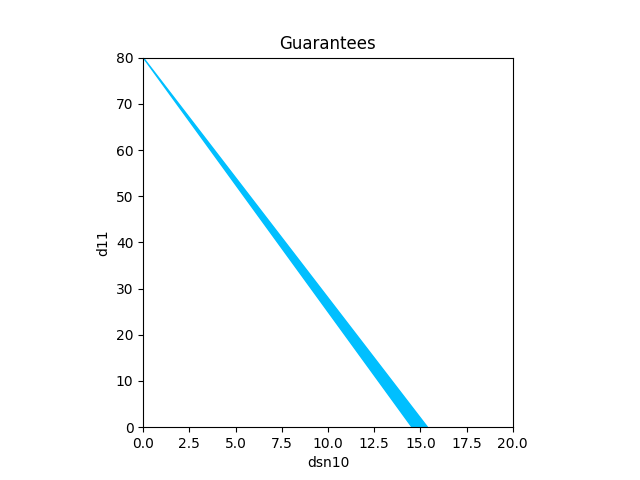

In [7]:
# - s: start index of the timeline variables
# - speed: (min, max) downlink rate during the task instance
# - epsilon: approximately zero
def DSN_data(s: int, speed: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"d{s}",          # initial data volume
      f"knob_dsn{s}",   # variable task duration
    ],
    OutputVars = [
      f"d{e}",          # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-knob_dsn{s} <= 0",

      # There is data to downlink: d{s} >= 1
      f"-d{s} <= -1",
    ],
    guarantees = [
      # duration*speed(min) <= d{s} - d{e} <= duration*speed(max)
      f" d{s} - d{e} - {speed[1]}*knob_dsn{s} <= 0",
      f"-d{s} + d{e} + {speed[0]}*knob_dsn{s} <= 0",

      # downlink cannot continue if there is no data left.
      f"-d{e} <= 0",
    ])
  return spec

dsn1_data = DSN_data(s=20, speed=(5.2, 5.5), epsilon=epsilon)
print(f"Contract dsn1_data:\n\n{dsn1_data}")

_ = plot_guarantees(contract=dsn1_data,
                x_var=Var("knob_dsn20"),
                y_var=Var("d21"),
                var_values={
                  Var("d20"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

##### DSN combined viewpoints

Pacti's contract merging operation allows us to compose the significant viewpoints (data and power) as well as add other viewpoints that are unaffected (trajectory progress and error, temperature of the thrusters). An important aspect of a design methodology pertains to the strategy for merging viewpoints. The example below corresponds to the early merging of domain-specific viewpoints for each scenario segment. Another strategy would instead merge the same domain-specific viewpoint across all scenario segments to provide an end-to-end assessment of the scenario feasibility within that domain-specific perspective before combining the constraints from other domains. 

In [8]:
dsn1 = \
  dsn1_data \
  .merge(dsn1_power) \
  .merge(nochangeContract(s=10,name="e")) \
  .merge(nochangeContract(s=10,name="r")) \
  .merge(nochangeContract(s=10,name="temp"))
print(f"dsn1:\n\n{dsn1}")

dsn1:

InVars: [d10, dsn10, soc10, e10, r10, temp10]
OutVars:[d11, soc11, e11, r11, temp11]
A: [
  -dsn10 <= 0.0
  -d10 <= -1.0
  4.2 dsn10 - soc10 <= 0.0
]
G: [
  d10 - d11 - 5.5 dsn10 <= 0.0
  -d10 + d11 + 5.2 dsn10 <= 0.0
  -d11 <= 0.0
  -4.2 dsn10 + soc10 - soc11 <= 0.0
  3.8 dsn10 - soc10 + soc11 <= 0.0
  -e10 + e11 = 0.0
  -r10 + r11 = 0.0
  -temp10 + temp11 = 0.0
]


In [10]:


dsn_pwr_power = connect(dsn1_power, pwr1_power, varPrefixes)
print(f"Power-focused composition of DSN and PWR contracts: dsn_pwr_power=\n\n{dsn_pwr_power}")


Power-focused composition of DSN and PWR contracts: dsn_pwr_power=

InVars: [soc10, dsn10, pwr20]
OutVars:[soc21]
A: [
  -pwr20 <= 0.0
  -dsn10 <= 0.0
  4.2 dsn10 - soc10 <= 0.0
]
G: [
  -4.2 dsn10 + 3.0 pwr20 + soc10 - soc21 <= 0.0
  3.8 dsn10 - 4.0 pwr20 - soc10 + soc21 <= 0.0
  soc21 <= 100.0
]


#### SBO Task (Small body observations)

This function affects three viewpoints, each with impacts that are linear with the duration of the task:
- data: the science data volume grows proportionally to a generation rate
- power: the battery discharges proportionally to a consumption rate
- navigation: the trajectory estimation error decreases proportionally to an improvement rate.

##### SBO data viewpoint

Contract sbo1_data:

InVars: [d30, sbo30]
OutVars:[d31]
A: [
  -sbo30 <= 0.0
  d30 + 4.0 sbo30 <= 100.0
]
G: [
  -d30 + d31 - 4.0 sbo30 <= 0.0
  d30 - d31 + 3.0 sbo30 <= 0.0
]


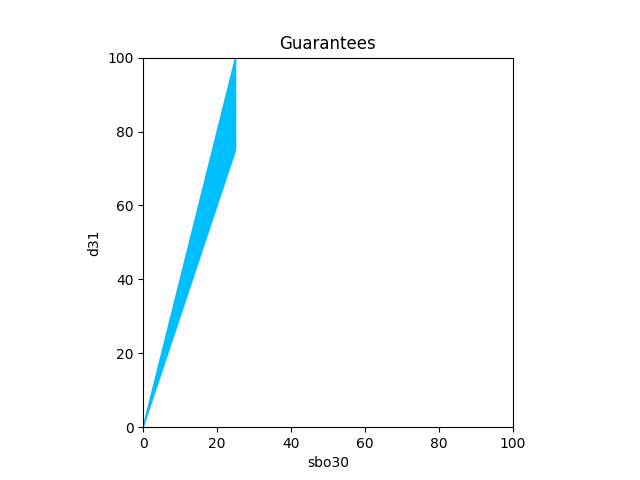

In [12]:
# Parameters:
# - s: start index of the timeline variables
# - generation: (min, max) rate of small body observations during the task instance
# - epsilon: approximately zero
def SBO_data(s: int, generation: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"d{s}",    # initial data volume
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"d{e}",    # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # There is enough data storage available
      f"d{s} + {generation[1]}*sbo{s} <= 100",
    ],
    guarantees = [
      # duration*generation(min) <= d{e} - d{s} <= duration*generation(max)
      f" d{e} - d{s} - {generation[1]}*sbo{s} <= 0",
      f"-d{e} + d{s} + {generation[0]}*sbo{s} <= 0",

      # Data volume cannot exceed the available storage capacity
      f"d{e} <= 100",
    ])
  return spec

sbo1_data = SBO_data(s=30, generation=(3.0, 4.0), epsilon=epsilon)
print(f"Contract sbo1_data:\n\n{sbo1_data}")

_ = plot_guarantees(contract=sbo1_data,
                x_var=Var("sbo30"),
                y_var=Var("d31"),
                var_values={
                  Var("d30"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

##### SBO power viewpoint

Contract sbo1_power:

InVars: [soc30, sbo30]
OutVars:[soc31]
A: [
  -sbo30 <= 0.0
  1.4 sbo30 - soc30 <= 0.0
]
G: [
  -1.4 sbo30 + soc30 - soc31 <= 0.0
  sbo30 - soc30 + soc31 <= 0.0
]


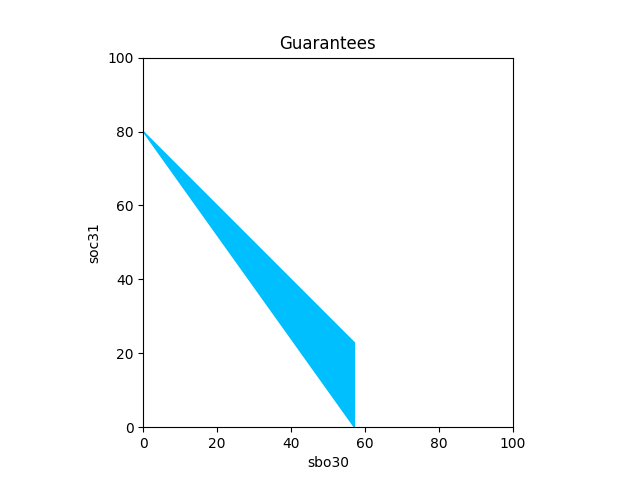

In [13]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
# - epsilon: approximately zero
def SBO_power(s: int, consumption: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"soc{s}",  # initial battery SOC
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"soc{e}",  # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # Battery has enough energy for consumption for the task instance
      f"-soc{s} + {consumption[1]}*sbo{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{s} - soc{e} <= duration*consumption(max)
      f" soc{s} - soc{e} - {consumption[1]}*sbo{s} <= 0",
      f"-soc{s} + soc{e} + {consumption[0]}*sbo{s} <= 0",

      # Battery should not completely discharge
      f"-soc{e} <= 0",
    ])
  return spec

sbo1_power = SBO_power(s=30, consumption=(1.0, 1.4), epsilon=epsilon)
print(f"Contract sbo1_power:\n\n{sbo1_power}")

_ = plot_guarantees(contract=sbo1_power,
                x_var=Var("sbo30"),
                y_var=Var("soc31"),
                var_values={
                  Var("soc30"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

##### SBO navigation viewpoint

Contract sbo1_nav:

InVars: [e30, sbo30]
OutVars:[e31]
A: [
  -sbo30 <= 0.0
  e30 <= 100.0
]
G: [
  e30 - e31 - 0.6 sbo30 <= 0.0
  -e30 + e31 + 0.4 sbo30 <= 0.0
  -e31 <= 0.0
]


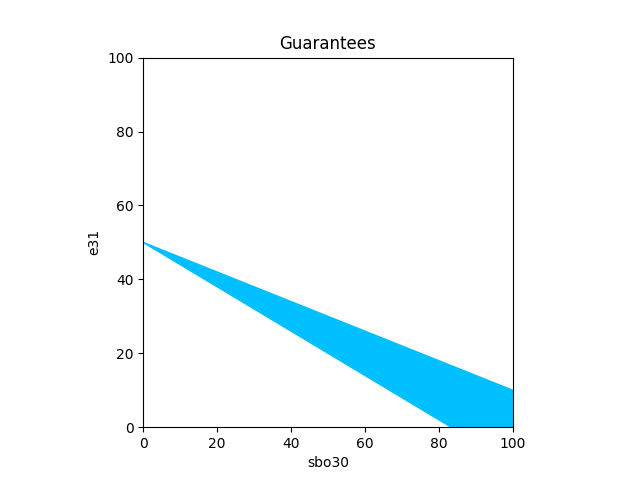

In [14]:
# Parameters:
# - s: start index of the timeline variables
# - improvement: rate of trajectory error improvement during the task instance
# - epsilon: approximately zero
def SBO_nav(s: int, improvement: tuple[float, float], epsilon: float) -> PolyhedralContract:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"e{s}",    # initial trajectory error
      f"sbo{s}",  # knob variable for SBO duration
    ],
    OutputVars = [
      f"e{e}",    # final trajectory error
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-sbo{s} <= 0",

      # Upper-bound on the trajectory estimation error
      f"e{s} <= 100",
    ],
    guarantees = [
      # duration*improvement(min) <= e{s} - e{e} <= duration*improvement(max)
      f" e{s} - e{e} - {improvement[1]}*sbo{s} <= 0",
      f"-e{s} + e{e} + {improvement[0]}*sbo{s} <= 0",

      # Lower-bound on the trajectory estimation error
      f"-e{e} <= 0",
    ])
  return spec

sbo1_nav = SBO_nav(s=30, improvement=(0.4, 0.6), epsilon=epsilon)
print(f"Contract sbo1_nav:\n\n{sbo1_nav}")

_ = plot_guarantees(contract=sbo1_nav,
                x_var=Var("sbo30"),
                y_var=Var("e31"),
                var_values={
                  Var("e30"):50,
                },
                x_lims=(0,100),
                y_lims=(0,100))

##### SBO combined viewpoints

In [15]:
sbo1 = \
  sbo1_data \
  .merge(sbo1_power) \
  .merge(sbo1_nav) \
  .merge(nochangeContract(s=30, name="r")) \
  .merge(nochangeContract(s=30, name="temp"))
print(f"sbo1:\n\n{sbo1}")

sbo1:

InVars: [d30, sbo30, soc30, e30, r30, temp30]
OutVars:[d31, soc31, e31, r31, temp31]
A: [
  -sbo30 <= 0.0
  d30 + 4.0 sbo30 <= 100.0
  1.4 sbo30 - soc30 <= 0.0
  e30 <= 100.0
]
G: [
  -d30 + d31 - 4.0 sbo30 <= 0.0
  d30 - d31 + 3.0 sbo30 <= 0.0
  -1.4 sbo30 + soc30 - soc31 <= 0.0
  sbo30 - soc30 + soc31 <= 0.0
  e30 - e31 - 0.6 sbo30 <= 0.0
  -e30 + e31 + 0.4 sbo30 <= 0.0
  -e31 <= 0.0
  -r30 + r31 = 0.0
  -temp30 + temp31 = 0.0
]


#### TCM Task (Perform a Trajectory Correction Maneuver)

This 

In [16]:
# TCM:
# Parameters:
# - s: start index of the timeline variables
# - max_error: maximum relative trajectory error before the task instance
# - heating_cost: total battery discharge due to the heating required before the TCM
# - delta: relative trajectory improvement as a result of the delta-V thrust performed in this task instance
def TCM_contract(s: int, max_error: float, heating_cost: float, delta: float, epsilon: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      # f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
      f"temp{s}", # initial spacecraft thruster temperature
      f"tcm{s}",  # knob variable for TCM duration
    ],
    OutputVars = [
      # f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
      f"temp{e}", # final spacecraft thruster temperature
    ],
    assumptions = [
      # Battery SOC has enough to perform the heating
      f"-soc{s} + {heating_cost}*tcm{s} <= 0",

      # Max trajectory error
      f"e{s} <= {max_error}",
    ],
    guarantees = [
      # task ends after the duration has elapsed
      # f"| t{e} - t{s} - tcm{s} | <= {epsilon}",

      # Battery discharges by at most heating_cost
      f"soc{s} + {heating_cost}*tcm{s} - soc{e} <= 0",

      # no change to the data volume
      f"| d{e} - d{s} | <= {epsilon}",

      # no change to trajectory error
      f"| e{e} - e{s} | <= {epsilon}",

      # trajectory improves by at least delta
      f"r{s} - r{e} <= -{delta}",

      # cold thruster temperature
      f"temp{e} <= {epsilon}",
    ])
  return e, spec

### Schedule examples

In [17]:
s1,init=initial_contract(epsilon=epsilon)
print("Contract init:")
print(init)


TypeError: cannot unpack non-iterable PolyhedralContract object

In [ ]:
s5,tcm1 = TCM_contract(s=40, max_error=4.0, heating_cost=40.0, delta=5.0, epsilon=epsilon)
print("Contract tcm1:")
print(tcm1)

In [ ]:
# This composition is well-formed; however, the variables are disjoint!
c0a = init.compose(sbo1)
print("Contract c0a = init.compose(sbo1):")
print(c0a)

In [ ]:
# Correct composition with a contract connector
c0b = connect(init, sbo1, varPrefixes)
print("Contract c0b = connect(init, sbo1, varPrefixes):")
print(c0b)

#### Creating the schedule of task instances by composing the task instance contracts (the compositions below are all wrong because the variables are disjoint!)

To compose contracts, we need to generate composable input/ouput variables.

In [ ]:
c1 = dsn1.compose(pwr1)
print("Contract dsn1.compose(pwr1):")
print(c1)

In [ ]:
c2 = c1.compose(sbo1)
print("Contract c1.compose(sbo1):")
print(c2)

In [ ]:
c3 = c2.compose(tcm1)
print("Contract c2.compose(tcm1):")
print(c3)

## References

<a id="ref1"></a> __[Chien et al. 2012](https://ai.jpl.nasa.gov/public/documents/papers/chien_spaceops2012_generalized.pdf)__

Chien, S.; Johnston, M.; Policella, N.; Frank, J.; Lenzen, C.; Giuliano, M.; and Kavelaars, A. 
**A generalized timeline representation, services, and interface for automating space mission operations.** 
In International Conference On Space Operations (SpaceOps 2012), Stockholm, Sweden, June 2012. 

<a id="ref2"></a> __[Rabideau et al. 2017](https://arc.aiaa.org/doi/pdf/10.2514/1.I010544)__

Rabideau, G.; Chien, S.; Galer, M.; Nespoli, F.; and Costa, M. 
**Managing Spacecraft Memory Buffers with Concurrent Data Collection and Downlink.** 
Journal of Aerospace Information Systems (JAIS). December 2017.

<a id="ref3"></a> __[Chen et al. 2003](https://www.researchgate.net/profile/Benjamin-Wah/publication/2861650_Automated_Planning_and_Scheduling_using_Calculus_of_Variations/links/54db35b20cf261ce15cf7)__

Chen, Y. and Wah, B. 
**Automated Planning and Scheduling using Calculus of Variations.**
13th International Conference on Automated Planning&Scheduling (ICAPS 2003), Trento, Italy, June 2003.

<a id="ref4"></a> __[Ghallab et al. 1998](https://planning.wiki/_citedpapers/pddl1998.pdf)__

Ghallab, M., Knoblock, C., Wilkins, D., Barrett, A., Christianson, D., Friedman, M., Kwok, C., Golden, K., Penberthy, S., Smith, D., Sun, Y., & Weld, D. (1998). 
**PDDL - The Planning Domain Definition Language.**

<a id="ref5"></a> __[Nesnas et al. 2021](https://www.frontiersin.org/articles/10.3389/frobt.2021.650885/full)__

Nesnas, I. A. D., Hockman, B. J., Bandopadhyay, S., Morrell, B. J., Lubey, D. P., Villa, J., Bayard, D. S., Osmundson, A., Jarvis, B., Bersani, M., Bhaskaran, S.
**Autonomous Exploration of Small Bodies Toward Greater Autonomy for Deep Space Missions**
In Frontiers in Robotics and AI, volume 8, November 2021.